# Kaggle Competition: Predict at which speed a pet is adopted

<img src="https://octodex.github.com/images/yaktocat.png" alt="Kit" title="Cat" width="250" height="150" />
Sofie and Alex Kaggle Competition

## Python Packages

In [132]:
# Import Packages

#Dataframe packages
import zipfile
import json
import objectpath
import pandas as pd 
import os
from PIL import Image
import requests
from io import BytesIO
import numpy as np

#Plot packages
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

## Datasets

The data is provided by [Petfinder.my](Petfinder.my) , a platform dedicated for pets adoption. 
The objective is to predict at which speed a pet is adopted. 

There are 6 different sources of data + Images + Metadata Images and Sentiment Data 
-   Train.csv
-   Test.csv
-   breed_labels.csv
-   color_labels.csv
-   state_labels.csv
-   Images (zip file) from cats and dogs that are adopted
-   Metadata Images (zip file) information about the Image using Google Vision API
-   Sentiment Data is based on the Descriptions using Google's Natural Language API. 


<img src="https://i.imgur.com/nGalhGi.jpg" alt="K" title="Cat" width="600" height="350" />

### Sentiment Data

In [2]:
# Define Empty lists
d = None  
data = None  
score=[]
petid=[]

# Read Zip File and Export a Dataset with the Score and the ID
with zipfile.ZipFile(r'C:\Users\alorenzodebrionne\Documents\Kaggle\train_sentiment.zip', "r") as z:
   for filename in z.namelist():  
      with z.open(filename) as f:  
         data = f.read()  
         d = json.loads(data.decode("utf-8"))
         json_tree = objectpath.Tree(d['documentSentiment'])
         result_tuple = tuple(json_tree.execute('$..score'))
         score.append(result_tuple)
         
      petid.append(filename.replace('.json',''))

# Output with sentiment data for each pet
sentimental_analysis = pd.concat([ pd.DataFrame(petid, columns =['PetID']) ,pd.DataFrame(score, columns =['score'])],axis =1)

### Image Metadata

In [3]:
# Define Empty lists
d = None  
data = None  
description=[]
imageid=[]

# Read Zip File and Export a Dataset with the Score and the ID
with zipfile.ZipFile(r'C:\Users\alorenzodebrionne\Documents\Kaggle\train_metadata.zip', "r") as z:
   for filename in z.namelist():  
      with z.open(filename) as f:  
          data = f.read()
          d = json.loads(data.decode("utf-8"))
          if 'labelAnnotations' in d:
             json_tree = objectpath.Tree(d['labelAnnotations'])
             image_metadata = tuple(json_tree.execute('$..description'))
             image_metadata = pd.DataFrame(list(image_metadata),columns=["label"])
             # Transpose to have 1 line per image
             image_metadata = image_metadata.transpose()
             # Count the number of columns
             col= len(image_metadata.columns)-1
             #Concatenate all columns
             image_metadata['image_metadata']=image_metadata.iloc[:,0:col].apply(lambda x: ','.join(x), axis=1)
             #Keep only all description variables
             image_metadata = image_metadata[['image_metadata']] 
             description.append(image_metadata.iloc[0,0])
         
         
             imageid.append(filename.replace('.json',''))

# Output with sentiment data for each pet
image_metadata = pd.concat([ pd.DataFrame(imageid, columns =['ImageId']) ,pd.DataFrame(description, columns =['label'])],axis =1)

#Per petID you have multiple picture let's transpose to have one line per Pet

# create the PetId variable
image_metadata['PetID'] = image_metadata['ImageId'].str.split('-').str[0]
#Tranpose the table 
image_metadata_raw = image_metadata.groupby('PetID').label.apply(list)
image_metadata_raw=pd.DataFrame(image_metadata_raw.tolist(), index=image_metadata_raw.index)
#Rename the variables
image_metadata_raw.columns = ['image_meta_' + str(col) for col in image_metadata_raw.columns]

### Adoption Data 

In [48]:
#Load Data
train =pd.read_csv('https://raw.githubusercontent.com/alexlorenzo/Pet.my/master/train.csv')
#test = pd.read_csv('https://raw.githubusercontent.com/alexlorenzo/Pet.my/master/test.csv')
breed =pd.read_csv('https://raw.githubusercontent.com/alexlorenzo/Pet.my/master/breed_labels.csv',usecols=["BreedID", "BreedName"]) #A pet could have multiple breed
color =pd.read_csv('https://raw.githubusercontent.com/alexlorenzo/Pet.my/master/color_labels.csv') #A pet could have multiple colors
state =pd.read_csv('https://raw.githubusercontent.com/alexlorenzo/Pet.my/master/state_labels.csv')

# Add information about color, breed, state and sentiment data
train = (pd.merge(train, breed.rename(columns={"BreedName": "BreedName1"}),  how='inner', left_on=['Breed1'], right_on = ['BreedID']).drop('BreedID', axis=1))
train = (pd.merge(train, breed.rename(columns={"BreedName": "BreedName2"}),  how='left', left_on=['Breed2'], right_on = ['BreedID']).drop('BreedID', axis=1))

train = (pd.merge(train, color.rename(columns={"ColorName": "ColorName1"}),  how='inner', left_on=['Color1'], right_on = ['ColorID']).drop('ColorID', axis=1))
train = (pd.merge(train, color.rename(columns={"ColorName": "ColorName2"}),  how='left', left_on=['Color2'], right_on = ['ColorID']).drop('ColorID', axis=1))
train = (pd.merge(train, color.rename(columns={"ColorName": "ColorName3"}),  how='left', left_on=['Color3'], right_on = ['ColorID']).drop('ColorID', axis=1))

train = (pd.merge(train, state,  how='inner', left_on=['State'], right_on = ['StateID']).drop('StateID', axis=1))

train = (pd.merge(train, sentimental_analysis,  how='left', left_on=['PetID'], right_on = ['PetID']))

# Add information about Metadata Images
#train = (pd.merge(train, image_metadata_raw, how='left', left_on ='PetID', right_index=True))


### Features Engineering

In [59]:
# Color (Create a Flag pet has 1 color, 2 colors, 3 colors)

train['L_Color1'] = (pd.isnull(train['ColorName3']) & pd.isnull(train['ColorName2']) & pd.notnull(train['ColorName1'])).astype(int)
train['L_Color2'] = (pd.isnull(train['ColorName3']) & pd.notnull(train['ColorName2']) & pd.notnull(train['ColorName1'])).astype(int)
train['L_Color3'] = (pd.notnull(train['ColorName3']) & pd.notnull(train['ColorName2']) & pd.notnull(train['ColorName1'])).astype(int)

# Breed (create a flag if the pet has 1 breed or 2)
train['L_Breed1'] = (pd.isnull(train['BreedName2']) & pd.notnull(train['BreedName1'])).astype(int)
train['L_Breed2'] = (pd.notnull(train['BreedName2']) & pd.notnull(train['BreedName1'])).astype(int)

#Name (create a flag if the name is missing, with less than two letters)
train['L_Name_missing'] =  (pd.isnull(train['Name'])).astype(int)
train['L_Name_incorrect']= (train.Name.str.contains("unname".lower())| train.Name.str.contains("unknow".lower())\
|train.Name.str.contains("no name".lower()) | (train['Name'].str.len() <3)).astype(int)

# Fee Amount
train['L_Fee_Free'] =  (train['Fee']==0).astype(int)
#Add the Number of Pets per Rescuer 
pets_total = train.groupby(['RescuerID']).size().reset_index(name='N_pets_total')
train= pd.merge(train, pets_total, left_on='RescuerID', right_on='RescuerID', how='inner')
train.count()

# No photo
train['L_NoPhoto'] =  (train['PhotoAmt']==0).astype(int)

#No Video
train['L_NoVideo'] =  (train['VideoAmt']==0).astype(int)

#Negative Score 
train['L_scoreneg'] =  (train['score']<0).astype(int)


## Adoption Data Exploration

In [6]:
train.head(100)

,RescuerID,N_pets_total,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,...,ColorName3,StateName,L_Color1,L_Color2,L_Color3,L_Breed1,L_Breed2,L_Name_missing,L_Name_incorrect,L_Fee_Free
0,0007e457eb0583479bb888d54764911f,1,2,Little Kittens,2,266,0,3,4,7,...,NaN,Selangor,0,1,0,1,0,0,0,1
1,0008ef529da74e9701db7eaaa4d9115a,2,1,Nutella,2,307,0,2,2,0,...,NaN,Selangor,1,0,0,1,0,0,0,1
2,0008ef529da74e9701db7eaaa4d9115a,2,1,Chip & Dale,6,307,307,1,2,0,...,NaN,Selangor,1,0,0,0,1,0,0,1
3,000a5830787b64da2d61b0bbceb7676d,4,2,Momo,2,266,0,2,1,3,...,White,Kuala Lumpur,0,0,1,1,0,0,0,1
4,000a5830787b64da2d61b0bbceb7676d,4,2,Mommy & 2 Kittens,1,266,0,3,1,3,...,Yellow,Kuala Lumpur,0,0,1,1,0,0,0,0
5,000a5830787b64da2d61b0bbceb7676d,4,2,Mimi,2,266,0,2,1,3,...,White,Kuala Lumpur,0,0,1,1,0,0,0,1
6,000a5830787b64da2d61b0bbceb7676d,4,2,Cik Mau,5,266,0,2,3,0,...,NaN,Kuala Lumpur,1,0,0,1,0,0,0,0
7,000acff3d6148772579b3e623988131b,1,1,Brownie,10,307,103,1,2,0,...,NaN,Kuala Lumpur,1,0,0,0,1,0,0,1
8,001b9870d4db6d26e2b52520dfbce249,1,2,"Archie - Sweet, Loving Boy!",24,266,0,1,3,4,...,NaN,Selangor,0,1,0,1,0,0,0,0
9,001e42763024f9d4abe31e79472b1827,61,2,Gemuk,12,265,0,2,1,7,...,NaN,Selangor,0,1,0,1,0,0,0,0


In [49]:
# As we see we will need to deal with missing values. 
# Variables with more than 50% of missing values will not be included in the model
train.count()

Type             14988
Name             13732
Age              14988
Breed1           14988
Breed2           14988
Gender           14988
Color1           14988
Color2           14988
Color3           14988
MaturitySize     14988
FurLength        14988
Vaccinated       14988
Dewormed         14988
Sterilized       14988
Health           14988
Quantity         14988
Fee              14988
State            14988
RescuerID        14988
VideoAmt         14988
Description      14976
PetID            14988
PhotoAmt         14988
AdoptionSpeed    14988
BreedName1       14988
BreedName2        4226
ColorName1       14988
ColorName2       10518
ColorName3        4387
StateName        14988
score            14437
dtype: int64

### Target Analysis


 -   0 - Pet was adopted on the same day as it was listed.
 -   1 - Pet was adopted between 1 and 7 days (1st week) after being listed.
 -   2 - Pet was adopted between 8 and 30 days (1st month) after being listed.
 -   3 - Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed.
 -   4 - No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days).


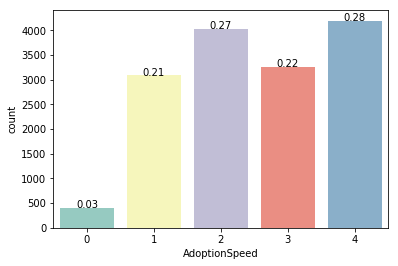

In [8]:
total = float(len(train)) # one person per row 
ax =sns.countplot(x="AdoptionSpeed", data=train,palette="Set3")
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height,
            '{:1.2f}'.format(height/total),
            ha="center") 


### Target vs dependant variables

#### Graphic function

In [9]:
def graphics (train, target, features, ncat):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

    sns.countplot(x=target,hue=i, data=train,palette=('#00a1ff','#f9bc86','#f85cc2')).set_title('Distribution of Adoption Speed per '+ i)
 
    # CrossTab
    cross = pd.crosstab(train[target],train[i],margins=True)
    # Delete the All obs. per variable y
    cross = cross.drop(cross.index[len(cross)-1])
    
    for j in ncat:
        # Stacked Bar Plot
        if j ==0:
            Type1 = pd.DataFrame(cross.iloc[:,j]/cross['All'])
            ax1.bar(Type1.index.values, Type1[0], color='#00a1ff', label=cross.columns[0])
        if j==1:
            Type2 = pd.DataFrame(cross.iloc[:,j]/cross['All'])
            ax1.bar(Type2.index.values, Type2[0], bottom=Type1[0], color='#f9bc86', label=cross.columns[1])
        if j ==2:
            Type3 = pd.DataFrame(cross.iloc[:,j]/cross['All'])
            ax1.bar(Type3.index.values, Type3[0], bottom=[z+t for z,t in zip(Type1[0],Type2[0])], color='#f85cc2', label=cross.columns[2])
        if j ==3:
            Type4 = pd.DataFrame(cross.iloc[:,j]/cross['All'])
            ax1.bar(Type4.index.values, Type4[0], bottom=[n+z+t for n,z,t in zip(Type1[0],Type2[0],Type3[0])], color='#ef53c7', label=cross.columns[4])
 
    # Add title and axis names
    ax1.set_title('Adoption Speed vs '+i)
    ax1.set(xlabel='Adoption Speed', ylabel=i)
    ax1.legend(loc='upper right')

#### Animal Type Analysis

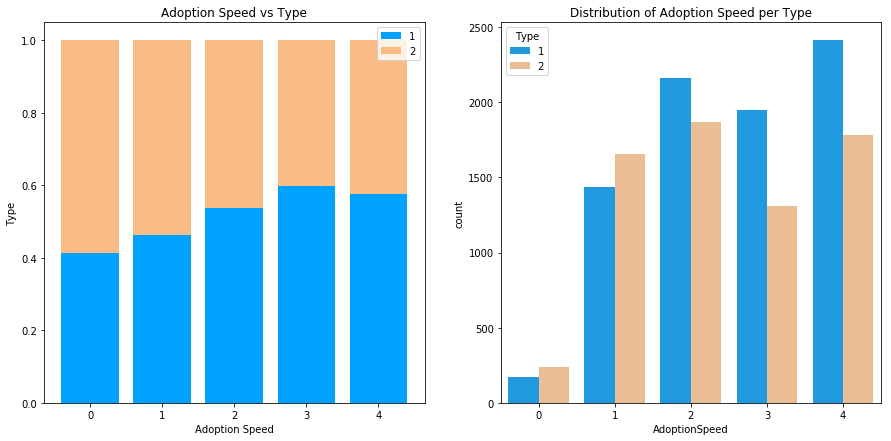

In [10]:
x= 'AdoptionSpeed'
features =["Type"]

for i in features:
    graphics(train,'AdoptionSpeed','Type',ncat=range(0,2))    #1. Dog 2.Cat

-  Type 1: Dog - Type 2: Cat. We see that cats are adopted more faster than dogs. 

#### Gender Analysis 

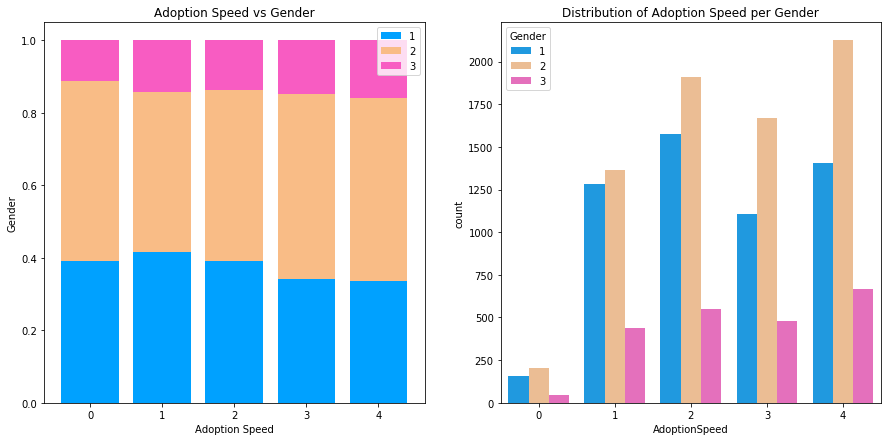

In [11]:
features=["Gender"]
for i in features:
    graphics(train,"AdoptionSpeed",i,ncat=range(0,3))    #1. Male, 2.Female 3. Mixed

-  More than one animals have tendance to be adopted after

#### Health Analysis

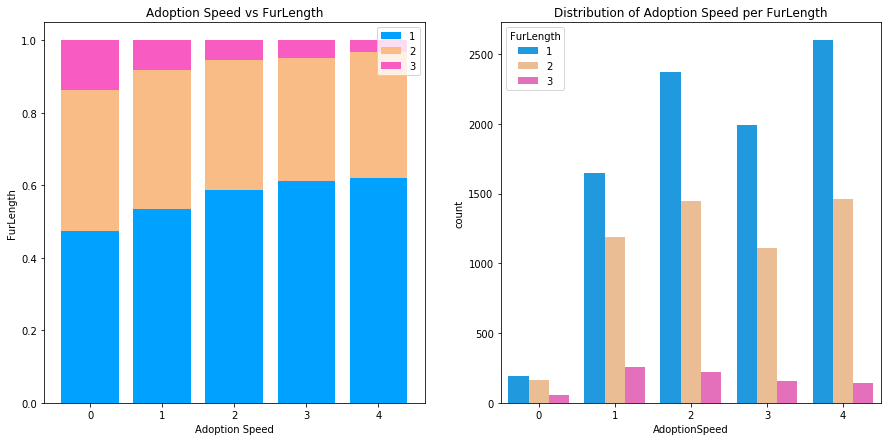

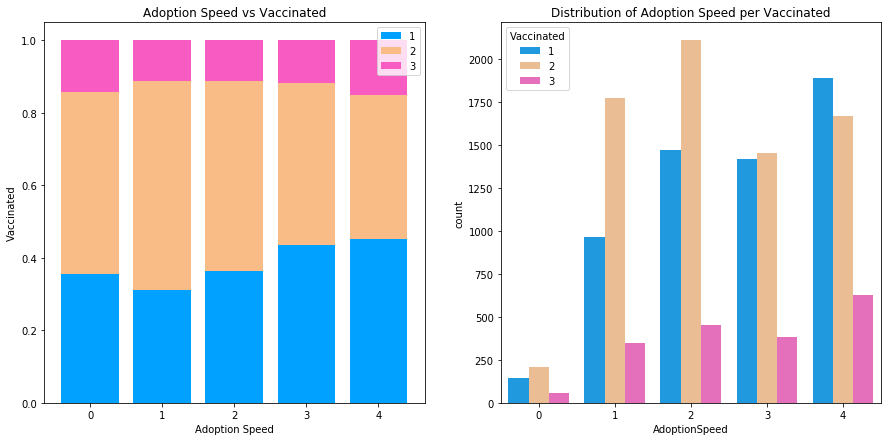

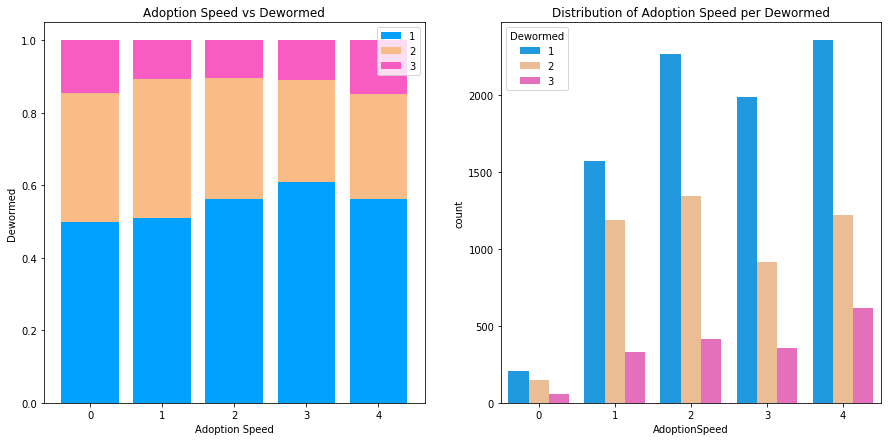

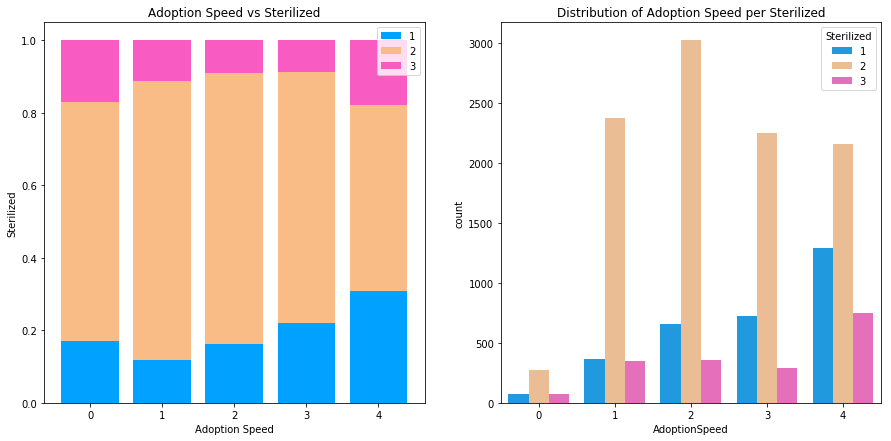

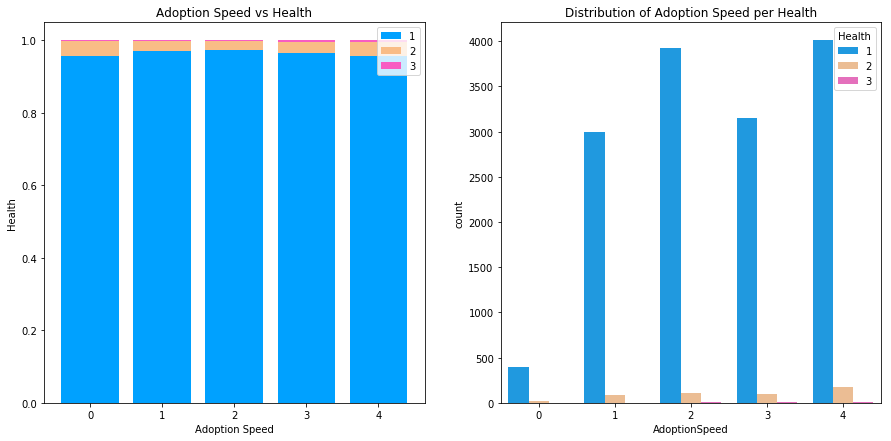

In [12]:
# Draw a nested analysis per Target
features =['FurLength','Vaccinated','Dewormed','Sterilized','Health']
target = ['AdoptionSpeed']
for i in features:
    graphics(train,"AdoptionSpeed",i,ncat=range(0,3))   

In [13]:
# FurLength (0 = Not Specified) - Health (0 = Not Specified) No missing values

train.loc[train['FurLength'] == 0]
train.loc[train['Health'] == 0 ]

,RescuerID,N_pets_total,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,...,ColorName3,StateName,L_Color1,L_Color2,L_Color3,L_Breed1,L_Breed2,L_Name_missing,L_Name_incorrect,L_Fee_Free


-  A Longer Fur favorise animal adoption (Fur length (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified))
-  Vaccination doesn't seem to have an impact on adoption (1 = Yes, 2 = No, 3 = Not Sure)
-  Dewormed doesn't seem to have an impact on adoption ...
-  Sterilized either, they prefer non sterilized pets?
-  Majority of Pets are healthy and in general they prefer health pets. 

#### Age & Mature Size analysis

In [14]:
#Count how many pets per Age (months) and Adoption Speed group
grouped_data = train.groupby(['AdoptionSpeed'])
grouped_data['Age'].describe()

,count,mean,std,min,25%,50%,75%,max
AdoptionSpeed,,,,,,,,
0,410.0,10.451220,17.775118,0.0,2.0,3.0,12.0,120.0
1,3090.0,8.488350,15.746187,0.0,2.0,2.0,6.0,147.0
2,4036.0,8.825074,16.780842,0.0,2.0,3.0,6.0,156.0
3,3257.0,10.194965,18.676734,0.0,2.0,3.0,9.0,212.0
4,4195.0,13.656257,20.161605,0.0,3.0,6.0,15.0,255.0


-  The dataset contains young pets, 50% of them have less than 6 months.
-  We see that older pets are adopted slower or not adopted

Index([1, 2, 3, 4, 'All'], dtype='object', name='MaturitySize')


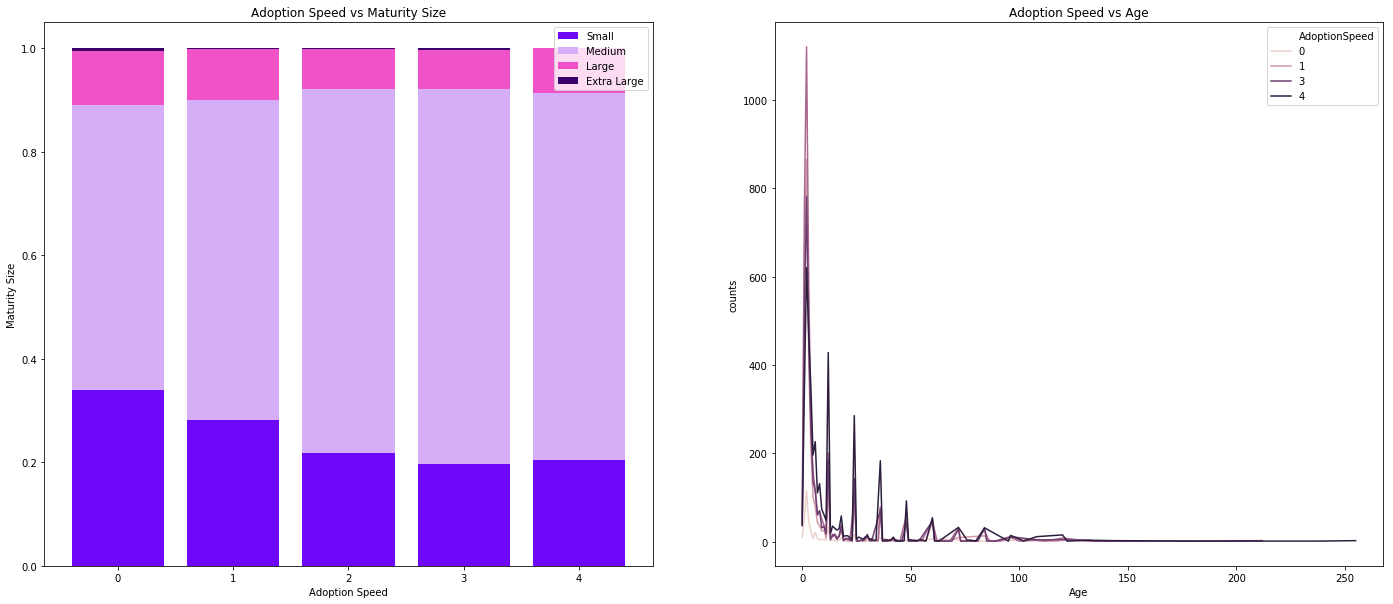

In [15]:
age_analysis =train.groupby(['Age', 'AdoptionSpeed']).size().reset_index(name='counts')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,10))

sns.lineplot(x="Age", y="counts", hue = "AdoptionSpeed",data=age_analysis).set_title("Adoption Speed vs Age")
# CrossTab
cross = pd.crosstab(train["AdoptionSpeed"],train['MaturitySize'],margins=True)
# Delete the All obs. per variable y
cross = cross.drop(cross.index[len(cross)-1])
print(cross.columns)
# Stacked Bar Plot
Type1 = pd.DataFrame(cross[1]/cross['All'])
Type2 = pd.DataFrame(cross[2]/cross['All'])
Type3 = pd.DataFrame(cross[3]/cross['All'])
Type4 = pd.DataFrame(cross[4]/cross['All'])

ax1.bar(Type1.index.values, Type1[0], label='Small', color='#6f07f9')
ax1.bar(Type2.index.values, Type2[0], bottom=Type1[0], color='#d6adf7', label='Medium')
ax1.bar(Type3.index.values, Type3[0], bottom=[z+t for z,t in zip(Type1[0], Type2[0])], label='Large', color='#ef53c7')
ax1.bar(Type4.index.values, Type4[0], bottom=[s+t+z for s,z,t in zip(Type1[0], Type2[0],Type3[0])], label='Extra Large', color='#3b006b')

# Add title and axis names
ax1.set_title('Adoption Speed vs Maturity Size')
ax1.set(xlabel='Adoption Speed', ylabel="Maturity Size")
ax1.legend(loc='upper right')


-  Small and Large pets are adopted faster

#### Color pets analysis

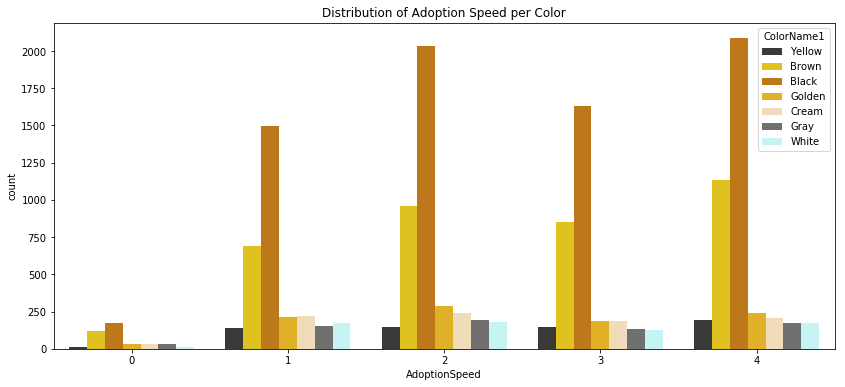

In [16]:
plt.figure(figsize=(14,6))
sns.countplot(x="AdoptionSpeed",hue="ColorName1", data=train,palette=('#393938','#ffd700','#d87c01',"#febf09","#f9dfb0","#707070","#befbfc")).set_title('Distribution of Adoption Speed per Color')

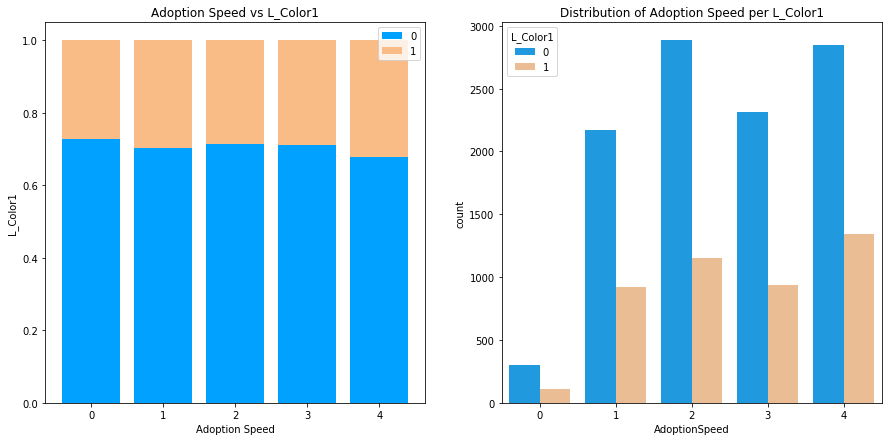

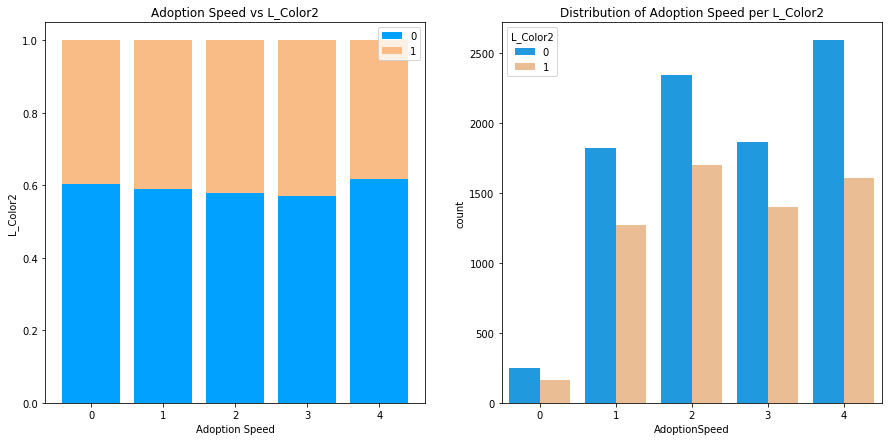

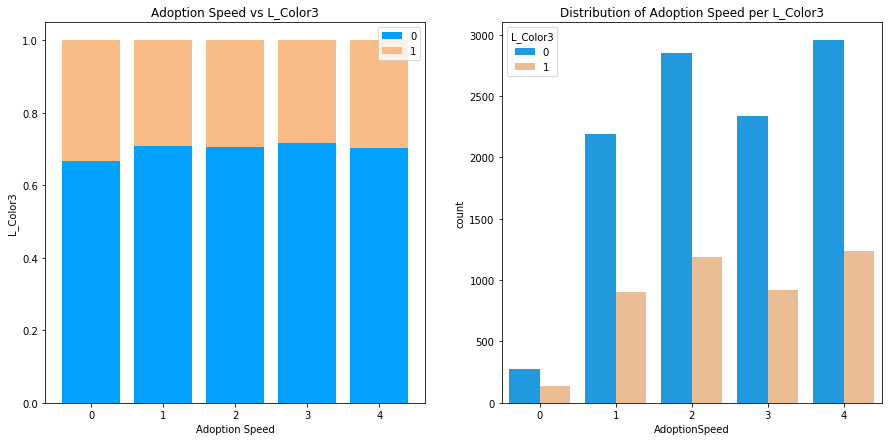

In [17]:
# Draw a nested analysis per Target
features =['L_Color1','L_Color2','L_Color3']
target = ['AdoptionSpeed']
for i in features:
    graphics(train,"AdoptionSpeed",i,ncat=range(0,2))   

-  1 Color or multiple colors doesn't seem to have an impact on Adoption Speed

#### Breed analysis

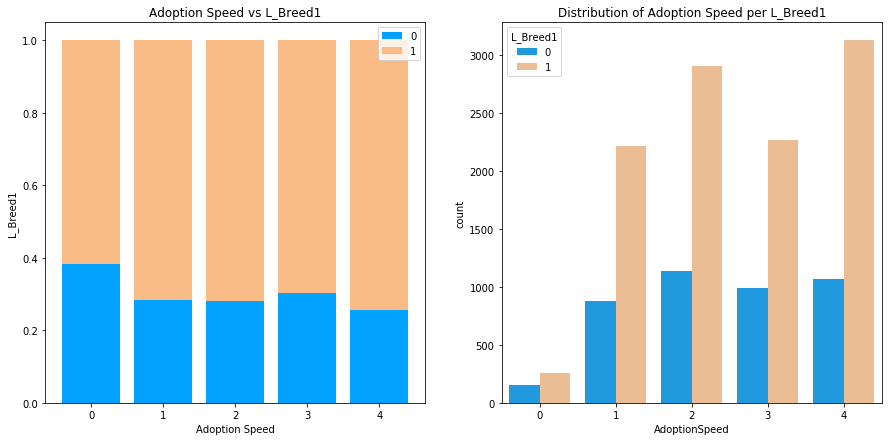

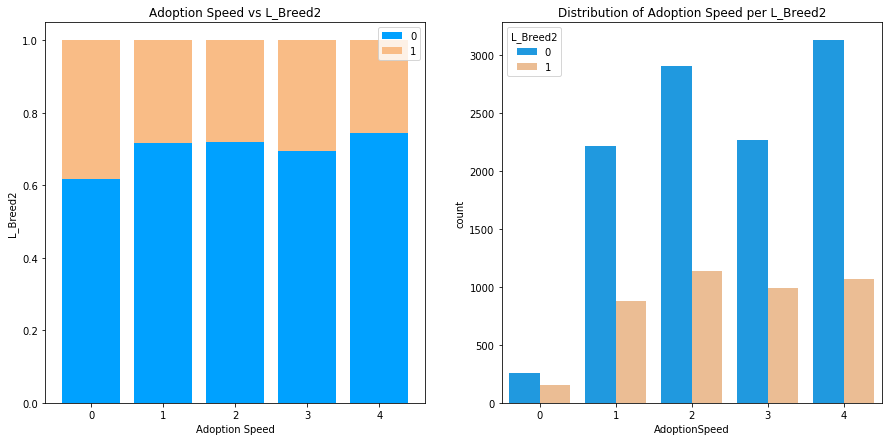

In [18]:
# Draw a nested analysis per Target
features =['L_Breed1','L_Breed2']
target = ['AdoptionSpeed']
for i in features:
    graphics(train,"AdoptionSpeed",i,ncat=range(0,2))   

-  Cat or dog with 2 breeds may have higher speed adption

#### Fee Adoption 

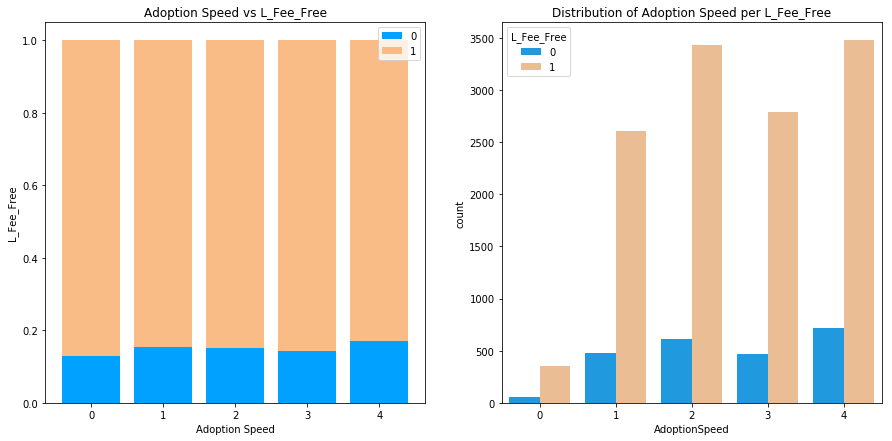

In [21]:
# Free Adoption 
features =['L_Fee_Free']
target = ['AdoptionSpeed']
for i in features:
    graphics(train,"AdoptionSpeed",i,ncat=range(0,2))   

-  Most animals are charge free 

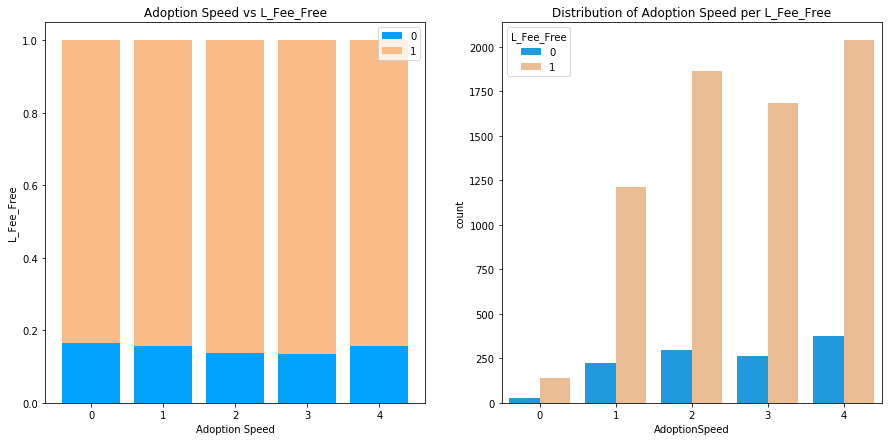

In [22]:
# Free Adoption Dogs 
features =['L_Fee_Free']
target = ['AdoptionSpeed']
for i in features:
    graphics(train.query('Type==1'),"AdoptionSpeed",i,ncat=range(0,2))   

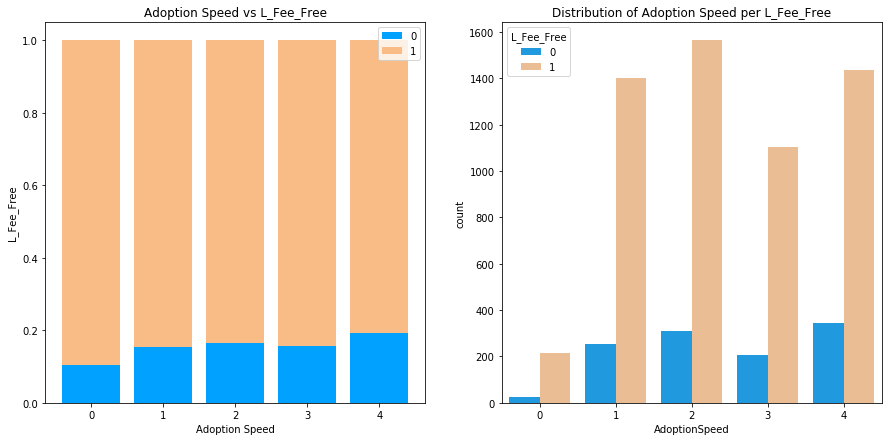

In [23]:
# Free Adoption Cats 
features =['L_Fee_Free']
target = ['AdoptionSpeed']
for i in features:
    graphics(train.query('Type==2'),"AdoptionSpeed",i,ncat=range(0,2))   

In [24]:
fee_analysis =train.query('Fee>0').groupby(['AdoptionSpeed'])
fee_analysis['Fee'].describe()


,count,mean,std,min,25%,50%,75%,max
AdoptionSpeed,,,,,,,,
0,53.0,170.849057,184.041320,1.0,50.0,100.0,200.0,1000.0
1,479.0,140.774530,163.265164,1.0,50.0,100.0,200.0,2000.0
2,607.0,143.540362,156.574884,1.0,50.0,100.0,200.0,1000.0
3,469.0,140.027719,185.578252,1.0,50.0,100.0,200.0,3000.0
4,720.0,124.113889,115.791373,1.0,50.0,100.0,160.0,750.0


-  The result is interesting for No adoption after 100 days the fee is less higher (in mean) than for the Adoption between 1 and 10 days 
- Free cats seems to be adopted faster

#### State analysis

<img src="https://i.imgur.com/NWIf9Gf.png" alt="state" title="state" width="600" height="400" /> 

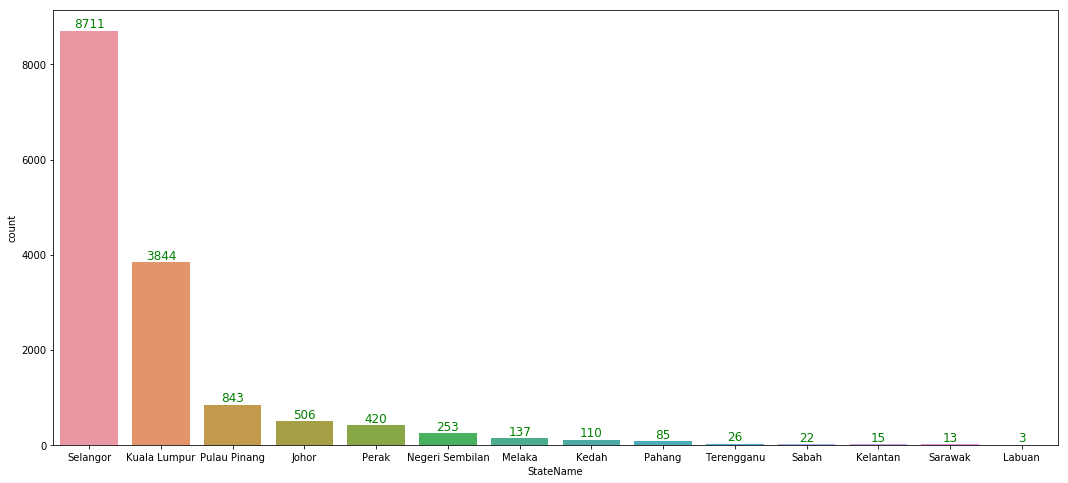

In [25]:
fig= plt.subplots(figsize=(18,8))
ax = sns.countplot(x="StateName", data=train, order = train["StateName"].value_counts().index)
# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, color='green', ha='center', va='bottom')

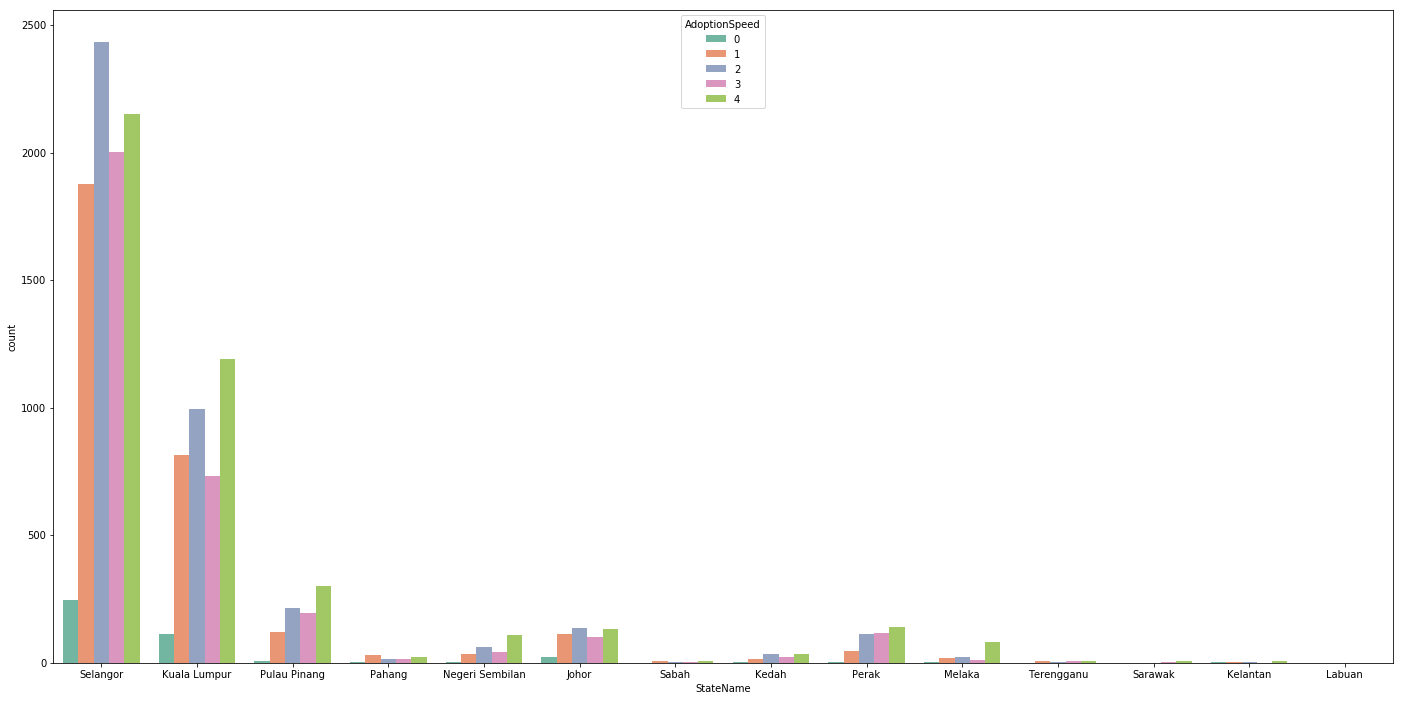

In [26]:
fig= plt.subplots(figsize=(24,12))
ax = sns.countplot(x="StateName",  hue="AdoptionSpeed",data=train, palette="Set2")

-  In Kuala Lumpur and Pulau Pinang the process seems slower 

#### RescuerID analysis

Number of pets per Rescuer and List the Top 10 Rescuer

In [34]:
rescuer_analysis =train.groupby(['RescuerID']).size().reset_index(name='counts')
rescuer_analysis['counts'].describe()

count    5592.000000
mean        2.680258
std        10.387263
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max       459.000000
Name: counts, dtype: float64

-  In mean a Rescuer have around 2 pets, let's see the top Rescuer ! 

In [35]:
Top4 =rescuer_analysis.sort_values('counts',ascending=False).head(4)
Top4

,RescuerID,counts
5482,fa90fa5b1ee11c86938398b60abc32cb,459
3766,aa66486163b6cbc25ea62a34b11c9b91,315
4226,c00756f2bdd8fa88fc9f07a8309f7d5d,231
3994,b53c34474d9e24574bcec6a3d3306a0d,228


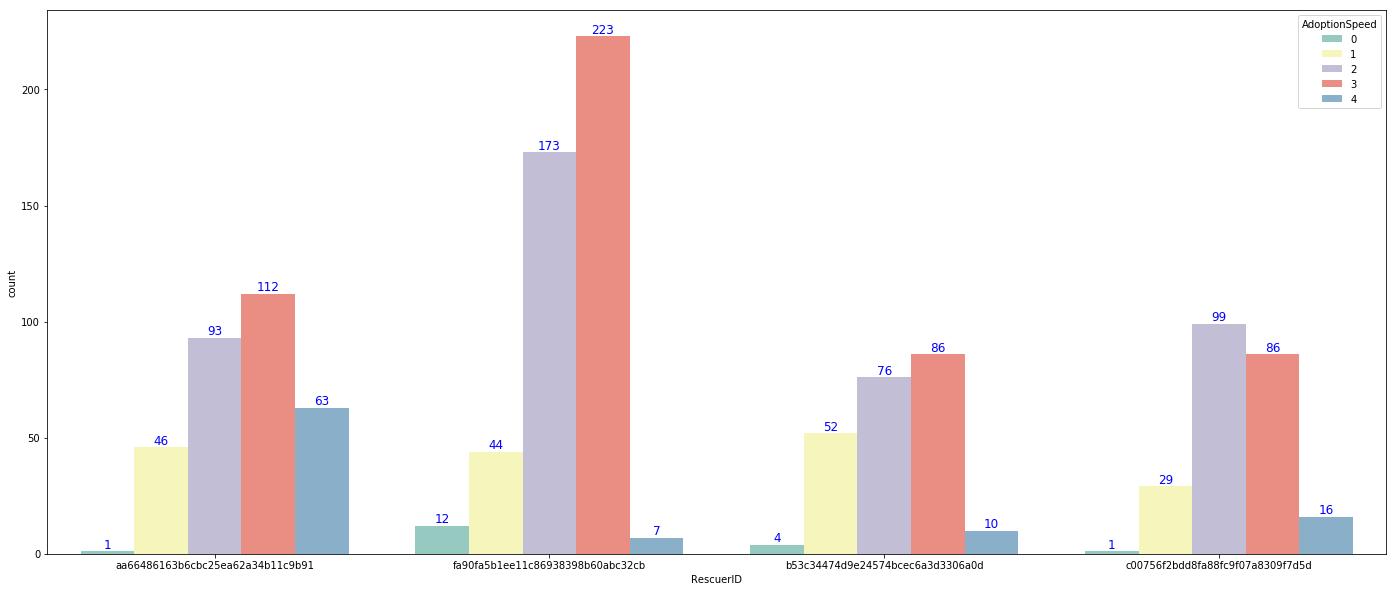

In [36]:
train_toprescuer = train.loc[train['RescuerID'].isin(Top4['RescuerID'].values.tolist())]

fig = plt.subplots(figsize=(24,10))

ax = sns.countplot(x="RescuerID",data=train_toprescuer ,hue="AdoptionSpeed" ,palette="Set3")
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, color='blue', ha='center', va='bottom') 

- the First Rescuer seems to have faster adoption

###### Rescuer with more pets have higher Adoption Rate? YES!

In [27]:
# Best Rescuer for minimum 10 pets
rescuer_speed =train.groupby(['RescuerID','AdoptionSpeed']).size().reset_index(name='N_pets_speed')

pets_total = train.groupby(['RescuerID']).size().reset_index(name='N_pets_total')
rescuer_analysis= pd.merge(pets_total, rescuer_speed, left_on='RescuerID', right_on='RescuerID', how='inner')
rescuer_analysis['pct_pets'] = rescuer_analysis['N_pets_speed']/rescuer_analysis['N_pets_total']

#Big Rescuer
rescuer_analysis.query("N_pets_total>10").groupby("AdoptionSpeed")['pct_pets'].describe().reset_index()


,AdoptionSpeed,count,mean,std,min,25%,50%,75%,max
0,0,56.0,0.092211,0.100268,0.003175,0.033065,0.064583,0.092572,0.500000
1,1,151.0,0.261362,0.171193,0.027027,0.125271,0.214286,0.360390,0.750000
2,2,167.0,0.329816,0.140831,0.040000,0.230769,0.337838,0.416667,0.733333
3,3,163.0,0.262902,0.136225,0.024390,0.156923,0.250000,0.354248,0.714286
4,4,123.0,0.271856,0.238099,0.015251,0.080128,0.187500,0.366029,1.000000


In [28]:
#Small Rescuer
rescuer_analysis.query("N_pets_total<10").groupby("AdoptionSpeed")['pct_pets'].describe().reset_index()

,AdoptionSpeed,count,mean,std,min,25%,50%,75%,max
0,0,252.0,0.716601,0.333763,0.111111,0.4,1.0,1.0,1.0
1,1,1423.0,0.739264,0.303898,0.111111,0.5,1.0,1.0,1.0
2,2,1538.0,0.750468,0.301336,0.111111,0.5,1.0,1.0,1.0
3,3,1201.0,0.722105,0.313204,0.111111,0.5,1.0,1.0,1.0
4,4,2424.0,0.882003,0.243132,0.111111,1.0,1.0,1.0,1.0


#### Video and Photo Analysis

In [33]:
train['PhotoAmt'].describe()

count    14988.000000
mean         3.888911
std          3.487733
min          0.000000
25%          2.000000
50%          3.000000
75%          5.000000
max         30.000000
Name: PhotoAmt, dtype: float64

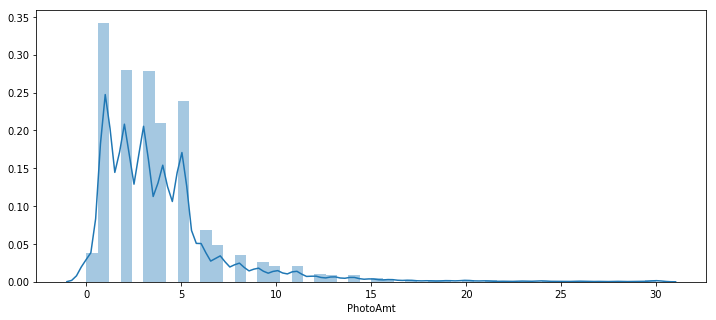

In [44]:
fig = plt.subplots(figsize=(12,5))
sns.distplot(train['PhotoAmt'])

In [39]:
train.groupby('AdoptionSpeed')['PhotoAmt'].mean()

AdoptionSpeed
0    3.324390
1    3.727184
2    4.070119
3    4.622659
4    3.319190
Name: PhotoAmt, dtype: float64

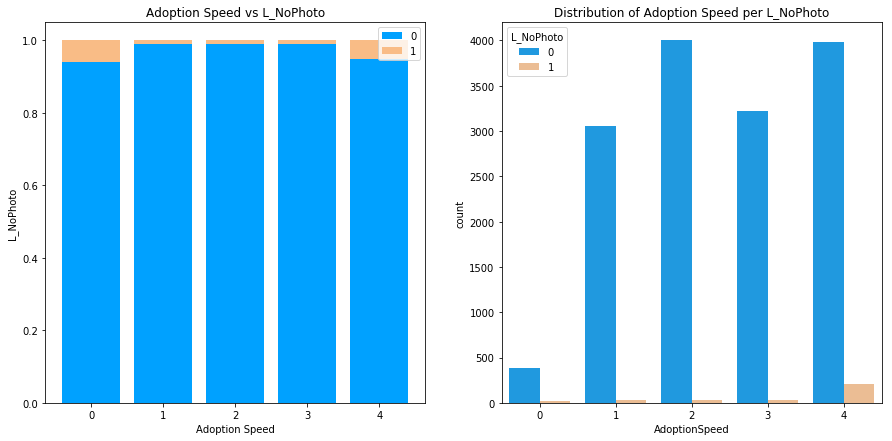

In [45]:
# Photo? 
features =['L_NoPhoto']
target = ['AdoptionSpeed']
for i in features:
    graphics(train,"AdoptionSpeed",i,ncat=range(0,2))   

In [35]:
train['VideoAmt'].describe()

count    14988.000000
mean         0.056779
std          0.346241
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          8.000000
Name: VideoAmt, dtype: float64

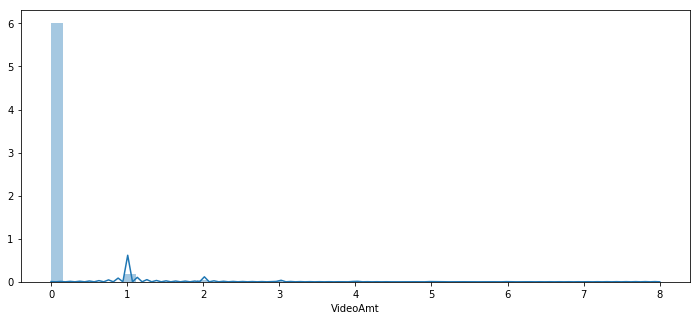

In [46]:
fig = plt.subplots(figsize=(12,5))
sns.distplot(train['VideoAmt'])

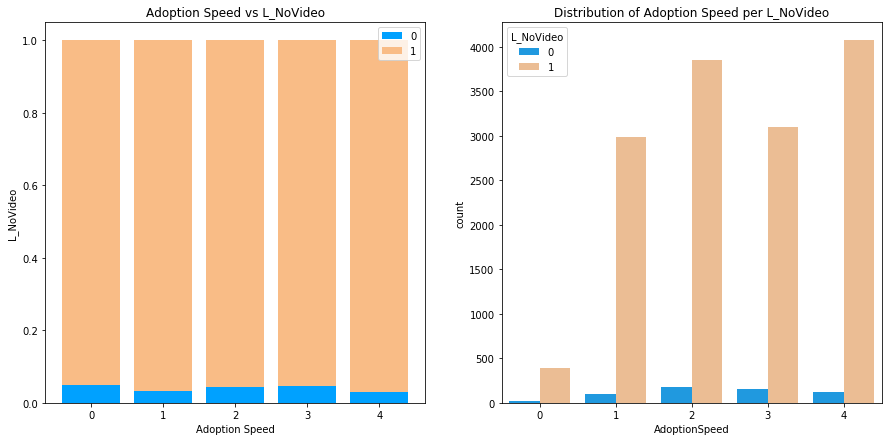

In [47]:
# Video? 
features =['L_NoVideo']
target = ['AdoptionSpeed']
for i in features:
    graphics(train,"AdoptionSpeed",i,ncat=range(0,2))   

-  Video and Photo Amount doesn't seem to have a huge impact on Adoption Speed

#### Sentiment Data Analysis

In [50]:
train.groupby('AdoptionSpeed')['score'].mean()

AdoptionSpeed
0    0.296094
1    0.266633
2    0.274341
3    0.274575
4    0.301416
Name: score, dtype: float64

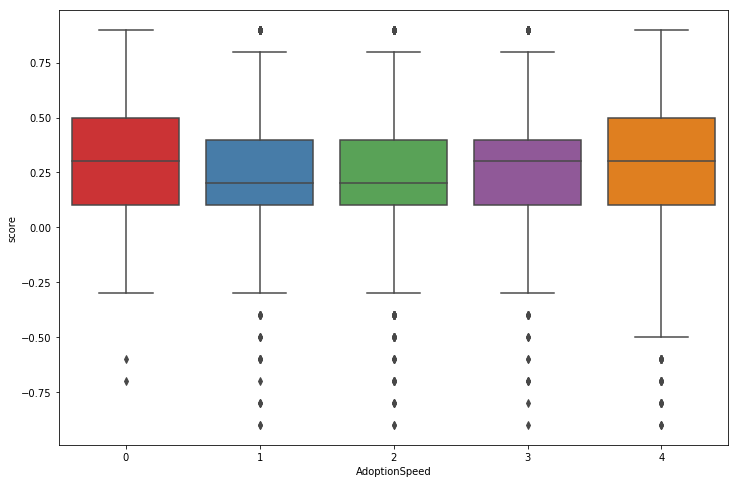

In [57]:
fig = plt.subplots(figsize=(12,8))
sns.boxplot(x='AdoptionSpeed', y='score', data=train, palette="Set1")

-  We see some more negative score when the Adoption is slower
-  Thus we create variable negative Score 

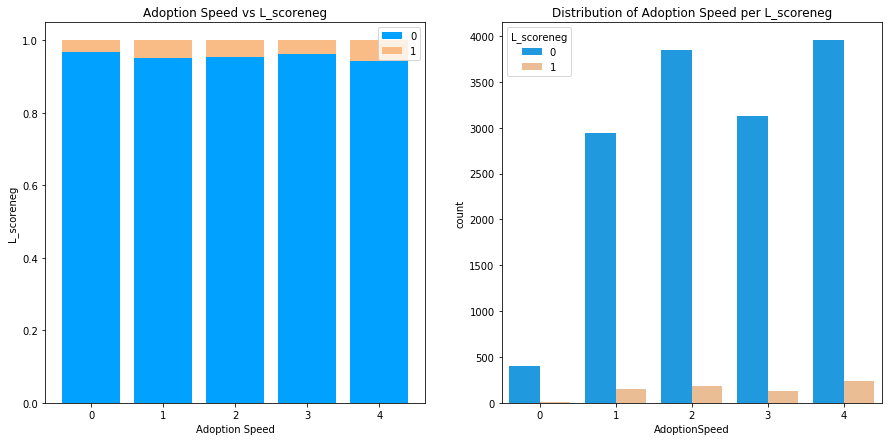

In [60]:
# Video? 
features =['L_scoreneg']
target = ['AdoptionSpeed']
for i in features:
    graphics(train,"AdoptionSpeed",i,ncat=range(0,2))   

#### Pet's Name Analysis

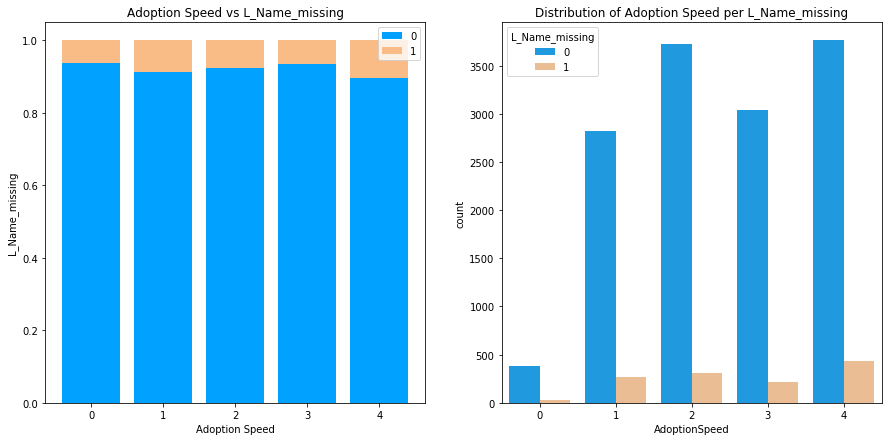

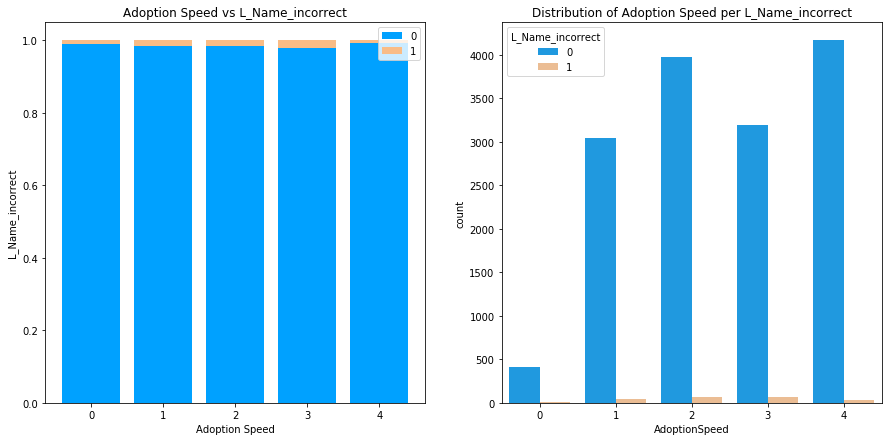

In [120]:
#Impact on missing name or incorrect name

features =['L_Name_missing','L_Name_incorrect']
target = ['AdoptionSpeed']
for i in features:
    graphics(train,"AdoptionSpeed",i,ncat=range(0,2))   

-  Missing Name has an impact on Adoption Speed. Let's Analyse the Name !

In [123]:
train_dog=train.loc[train['Type'] == 1]
train_cat=train.loc[train['Type'] == 2]

text_cat = ','.join(str(v) for v in train_cat.Name)
text_dog = ','.join(str(v) for v in train_dog.Name)
print ("There are {} words in the combination of all Name.".format(len(text_dog)))

There are 77955 words in the combination of all Name.


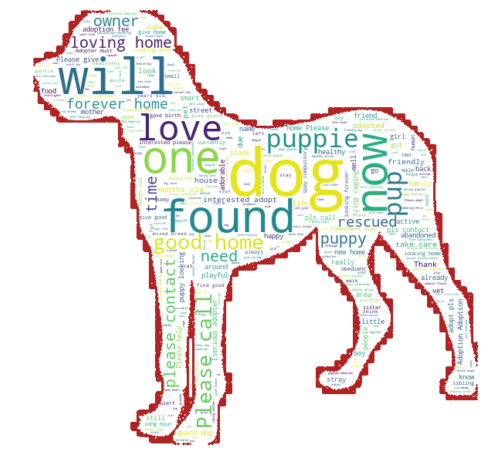

In [134]:
response_cat = requests.get("https://i.imgur.com/VIUvAxb.jpg")
cat_mask = np.array(Image.open(BytesIO(response_cat.content)))
response_dog = requests.get("https://i.imgur.com/IWGYuPN.jpg")
dog_mask = np.array(Image.open(BytesIO(response_dog.content)))

#dog_mask = np.array(Image.open(r"C:\Users\alorenzodebrionne\Pictures\dog.jpg"))
#cat_mask= np.array(Image.open(r"C:\Users\alorenzodebrionne\Pictures\cat.jpg"))

def word_cloud(text,mask):
    # Create a word cloud image
    wc = WordCloud(background_color="white", max_words=300, mask=mask,
                   contour_width=3, contour_color='firebrick')

    # Generate a wordcloud
    wc.generate(text)

    # show
    plt.figure(figsize=[15,8])
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

word_cloud(text_dog,dog_mask)

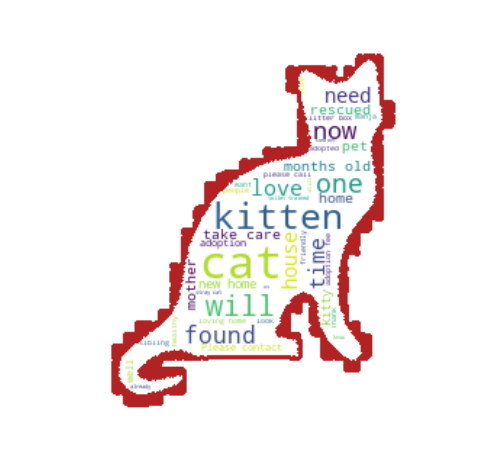

In [135]:
word_cloud(text_cat,cat_mask)

#### Image Metadata Analysis

<img src="https://i.imgur.com/iTSmFys.jpg" alt="pet" title="pet" width="400" height="300" />  Google API description : dog, dog breed, street dog, dog like mammal, dog breed group, snout, carnivoran...

In [128]:
text_cat = ','.join(str(v) for v in train_cat.Description)
text_dog = ','.join(str(v) for v in train_dog.Description)
print ("There are {} words in the combination of all Description for Cats.".format(len(text_cat)))

There are 149326 words in the combination of all Description.


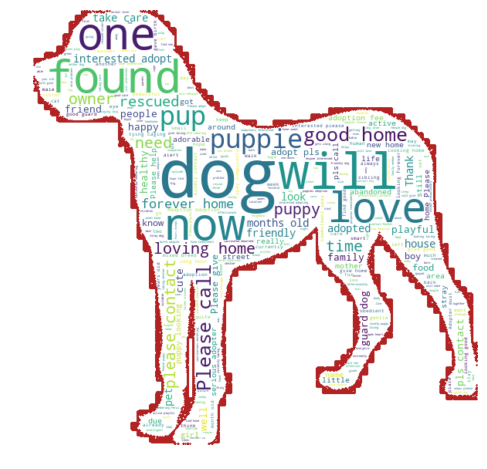

In [129]:
word_cloud(text_dog,dog_mask)

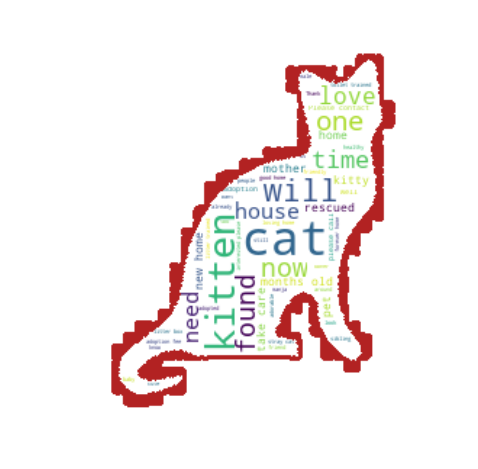

In [131]:
word_cloud(text_cat,cat_mask)